# PatchMatch

**Imports**

In [ ]:
# Navigate to appropriate directory
import os
while os.path.split(os.getcwd())[1] != "patchmatch":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from tqdm import tqdm
import opencv as cv

import patchmatch as pm

**Matplotlib display mode**

In [2]:
# Run this cell to display matplotlib plots in a separate window
%matplotlib qt

In [3]:
# Run this cell to display matplotlib plots inside the jupyter notebook
%matplotlib inline

In the following sections, we test the PatchMatch algorithm on 2 different images with copy-move forgery: one with a simple translation and one with a translation and a rotation.

## Image 1: Antibes

### Load image 

In [4]:
im = Image.open("data/TP_C02_007_copy.png")
im = np.array(im).astype("double")
gt = Image.open("data/TP_C02_007_gt.png")
gt = np.array(gt) > 0

### Initialize Patchmatch

Expected runtime with init_method=1 and zernike=True (p=10, max_zrd=6): 54s   
Expected runtime with init_method=2 and zernike=True (p=10, max_zrd=6): 55s   
Expected runtime with init_method=1 and zernike=False (p=10, max_zrd=6): 5s   
Expected runtime with init_method=2 and zernike=False (p=10, max_zrd=6): 5s   

In [5]:
t0 = time()
a = pm.PatchMatch(
    im,  # image
    p=10,  # patch half-size
    max_zrd=6,  # maximum Zernike degree
    min_dn=64,   # minimum displacement norm (previously T)
    n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
    init_method=2,  # whether to use create_vect_field1 or create_vect_field2
    zernike=True  # whether to use Zernike moments
)
t1 = time()
print(t1 - t0)

234.0875105857849


### Run PatchMatch

Expected running time with zernike=True (max_zrd=6): <10s for each iteration (1 iteration = 2 scans)

In [6]:
t0 = time()
a.run(5)
t1 = time()
print(t1 - t0)

Scan
1926338
Scan
1157614
Scan
761271
Scan
539334
Scan
398723
Scan
302884
Scan
238546
Scan
196147
Scan
165203
Scan
143243
88.0689914226532


In [7]:
a.get_min_displacement_norm()

64

### Plot results

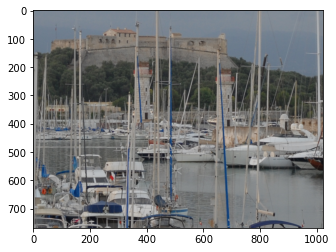

In [8]:
plt.imshow(im.astype("uint8"))

In [9]:
def plot_vect_field(pm_, mask, step=100, **kwargs):
    """
    Plot vect_field as arrows above the image
    
    Parameters
    ----------
    pm_ : instance of PatchMatch
    mask : array-like, shape (m, n)
        only vectors whose "roots" are on pixels for wich mask is non-zero will be plotted
    step : int
        step between two plotted vectors
    **kwargs : keyword arguments
        keyword arguments to be passed to plt.arrow (e.g. head_width, head_length, ...)
    """
    default_kwargs = {"width": 1e-3, "head_width": 1, "head_length": 1.5, "length_includes_head": True}
    default_kwargs.update(kwargs)
    default_kwargs["head_length"] = 1.5 * default_kwargs["head_width"]
    plt.imshow(pm_.im.astype("uint8"))
    for i in range(0, pm_.m, step):  # for each pixel in the mask
        for j in range(0, pm_.n, step):
            if mask[i, j] > 0:
                plt.arrow(j, i, *pm_.vect_field[i, j, ::-1], **default_kwargs)
    plt.axis("off")

FileNotFoundError: [Errno 2] No such file or directory: 'perso/antibes_arrows_zoomed.png'

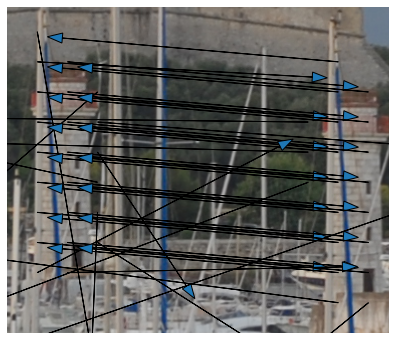

In [10]:
plt.figure(figsize=(16,6))
plot_vect_field(a, gt, step=30, head_width=10)
plt.xlim([330, 710])
plt.ylim([450, 125])
plt.savefig("perso/antibes_arrows_zoomed.png",bbox_inches='tight',dpi=100)
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,6))
plt.title('x component')
plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.axis("off")
plt.savefig("perso/antibes_x_component.png",bbox_inches='tight',dpi=100)
plt.show()
plt.figure(figsize=(16,6))
plt.title('y component')
plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.axis("off")
plt.savefig("perso/antibes_y_component.png",bbox_inches='tight',dpi=100)
plt.show()
# plt.figure(figsize=(16,6))
# plt.title('Norm of displacement vectors')
# plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
# plt.colorbar()
# plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch est son successeur')
plt.imshow(a.dist_field)
plt.colorbar()
plt.show()

In [ ]:
p = 10

def gradn(u):
    v = np.sqrt( (np.diff(u,axis=0)[:,:-1])**2 + (np.diff(u,axis=1)[:-1,:])**2 )
    return v

vx = gradn(a.vect_field[..., 0])
vy = gradn(a.vect_field[..., 1])
n, m = a.n, a.m

mask_0 = np.zeros((m,n))
mask_0[:-1,:-1] = 1*(vy<0.1)*(vx<0.1)

#Mean to eliminate noise
mask_1 = np.zeros((m,n))
r = 3
for i in tqdm(range(r, m - r)):
    for j in range(r, n - r):
        mask_1[i,j] = np.mean(mask_0[i-r+1:i+r,j-r+1:j+r])

#good threshold to keep just the mask
th = 0.5
mask_2 = 1*(mask_1>th)

#dilatation
mask = np.zeros((m,n))
for i in tqdm(range(m)):
    for j in range(n):
        mask[i,j] = np.max(mask_2[max(i-p+1,0):min(i+p,m-1),max(j-p+1,0):min(j+p,n-1)])

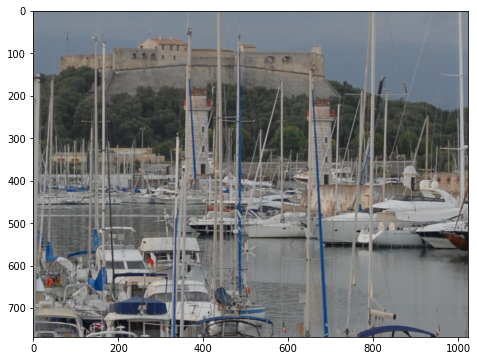

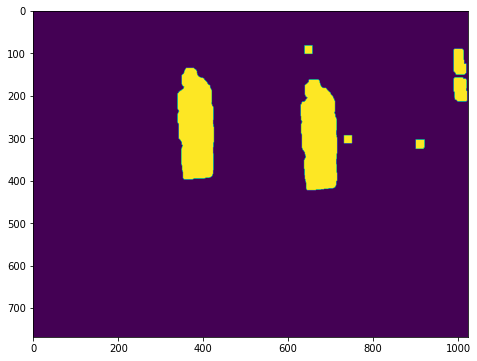

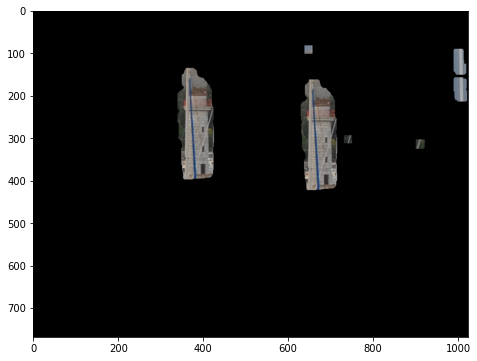

In [13]:
plt.figure(figsize=(16,6))
plt.imshow(im.astype("uint8"))
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,6))
plt.imshow((mask[:,:,None]*im).astype("uint8"))
plt.show()

# Image 2 : Leaf

In [14]:
# im = Image.open("data/feuille_copy_move.png")
# im = np.array(im).astype("double")

In [15]:
# t0 = time()
# a = pm.PatchMatch(
#     im,  # image
#     p=10,  # patch half-size
#     max_zrd=6,  # maximum Zernike degree
#     min_dn=64,   # minimum displacement norm (previously T)
#     n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
#     init_method=2,  # whether to use create_vect_field1 or create_vect_field2
#     zernike=True  # whether to use Zernike moments
# )
# t1 = time()
# print(t1 - t0)

In [16]:
# t0 = time()
# a.run(5)
# t1 = time()
# print(t1 - t0)

In [17]:
# plt.figure(figsize=(16,6))
# plt.imshow(im.astype("uint8"))
# plt.show()

# plt.figure(figsize=(16,6))
# pm.plot_vect_field(a, gt, step=30, head_width=10)
# plt.show()

# plt.figure(figsize=(16,6))
# plt.title('Composante x des vecteurs de déplacement')
# plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(16,6))
# plt.title('Composante y des vecteurs de déplacement')
# plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(16,6))
# plt.title('Norme des vecteurs de déplacement')
# plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(16,6))
# plt.title('Distance entre le patch est son successeur')
# plt.imshow(a.dist_field)
# plt.colorbar()
# plt.show()

In [18]:
# vx = gradn(a.vect_field[..., 0])
# vy = gradn(a.vect_field[..., 1])
# n, m = a.n, a.m

# mask_0 = np.zeros((m,n))
# mask_0[:-1,:-1] = 1*(vy<0.1)*(vx<0.1)

# #Mean to eliminate noise
# mask_1 = np.zeros((m,n))
# r = 3
# for i in tqdm(range(r, m - r)):
#     for j in range(r, n - r):
#         mask_1[i,j] = np.mean(mask_0[i-r+1:i+r,j-r+1:j+r])

# #good threshold to keep just the mask
# th = 0.2
# mask_2 = 1*(mask_1>th)

# #dilatation
# mask = np.zeros((m,n))
# for i in tqdm(range(m)):
#     for j in range(n):
#         mask[i,j] = np.max(mask_2[max(i-p+1,0):min(i+p,m-1),max(j-p+1,0):min(j+p,n-1)])

In [19]:
# plt.figure(figsize=(16,6))
# plt.imshow(im.astype("uint8"))
# plt.show()

# plt.figure(figsize=(16,6))
# plt.imshow(mask)
# plt.show()

# plt.figure(figsize=(16,6))
# plt.imshow((mask[:,:,None]*im).astype("uint8"))
# plt.show()

## Image 2: Flowers

### Load image 

In [20]:
im2 = Image.open("data/TP_C01_039_copy_r45.png")
im2 = np.array(im2).astype("double")
gt2 = Image.open("data/TP_C01_039_gt_r45.png")
gt2 = np.array(gt2) > 0

### Initialize Patchmatch

In [21]:
t0 = time()
a2 = pm.PatchMatch(
    im2,  # image
    p=10,  # patch half-size
    max_zrd=6,  # maximum Zernike degree
    min_dn=64,   # minimum displacement norm (previously T)
    n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
    init_method=2,  # whether to use create_vect_field1 or create_vect_field2
    zernike=True  # whether to use Zernike moments
)
t1 = time()
print(t1 - t0)

65.53342461585999


### Analyze Zernike moments

Plot Zernike filters

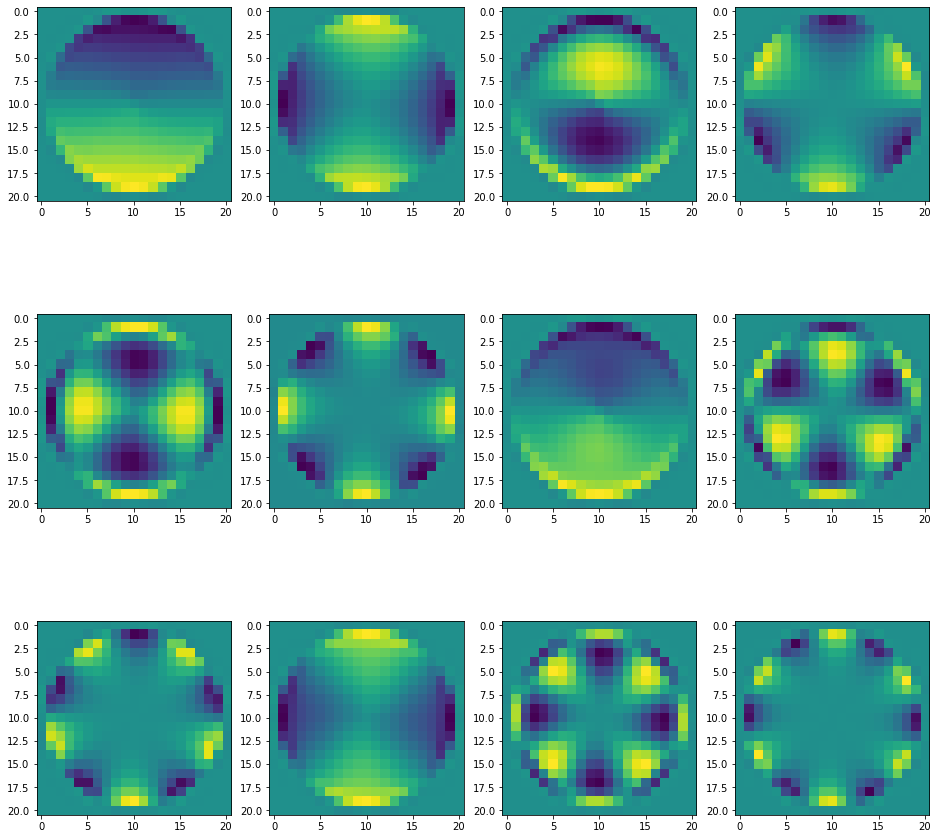

In [22]:
plt.figure(figsize=(16,16))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(a2.zernike_filters[..., i].real)
plt.show()

Get Zernike moments of 3 different patches: 1 et 2 should have the same Zernike moments (rotation invariance), whereas the "control" patch should be quite different.

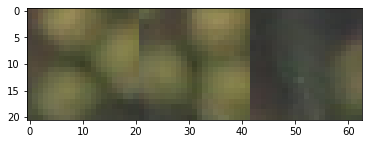

In [23]:
# Show patches 1, 2 and control
plt.imshow(np.concatenate((a2.patch(577, 768), a2.patch(379, 832), a2.patch(128, 988)), axis=1).astype("uint8"))
plt.show()

In [24]:
# Get their Zernike moments
zm1 = a2.zernike_moments[577, 768]
zm2 = a2.zernike_moments[379, 832]
zm_control = a2.zernike_moments[128, 988]

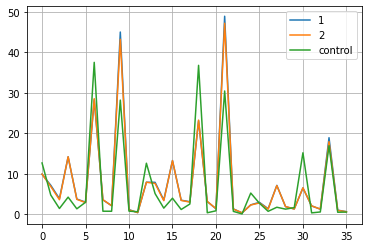

In [25]:
# Plot the Zernike moments
plt.plot(zm1, label="1")
plt.plot(zm2, label="2")
plt.plot(zm_control, label="control")
plt.legend()
plt.grid()
plt.show()

### Run PatchMatch

In [26]:
t0 = time()
a2.run(5)
t1 = time()
print(t1 - t0)

Scan
1965137
Scan
1233320
Scan
833390
Scan
592973
Scan
440791
Scan
333516
Scan
255016
Scan
203750
Scan
168349
Scan
144432
38.1082284450531


### Plot results

In [27]:
%matplotlib qt

In [28]:
%matplotlib inline

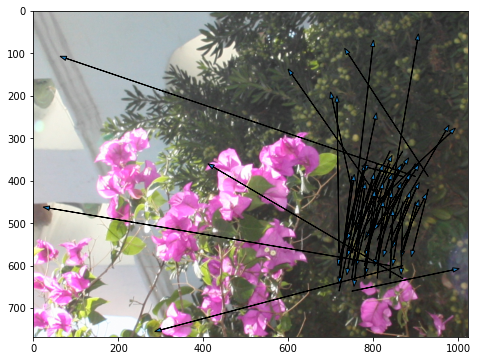

In [29]:
plt.figure(figsize=(16,6))
pm.plot_vect_field(a2, gt2, step=30, head_width=10)

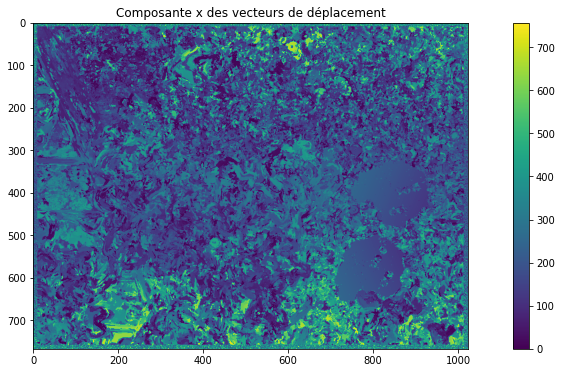

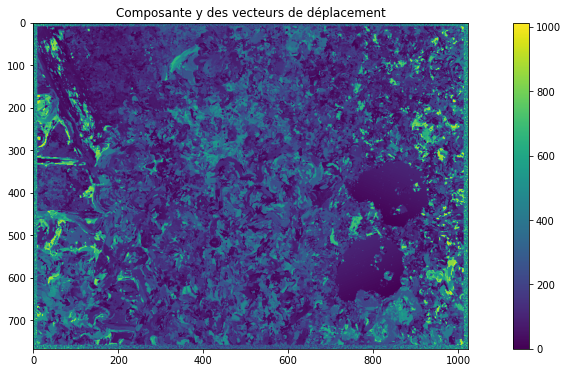

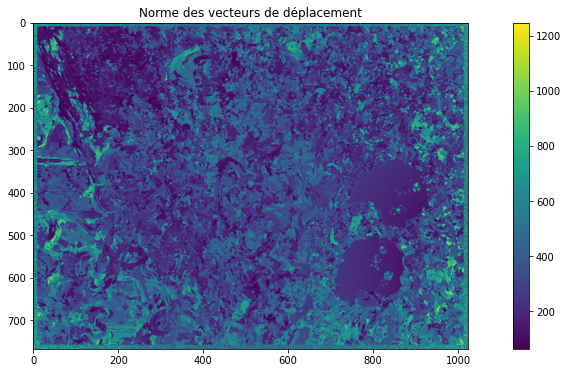

In [30]:
plt.figure(figsize=(16,6))
plt.title('Composante x des vecteurs de déplacement')
plt.imshow(np.abs(a2.vect_field[..., 0])) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Composante y des vecteurs de déplacement')
plt.imshow(np.abs(a2.vect_field[..., 1])) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Norme des vecteurs de déplacement')
plt.imshow(np.sqrt(a2.vect_field[..., 0]**2 + a2.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()

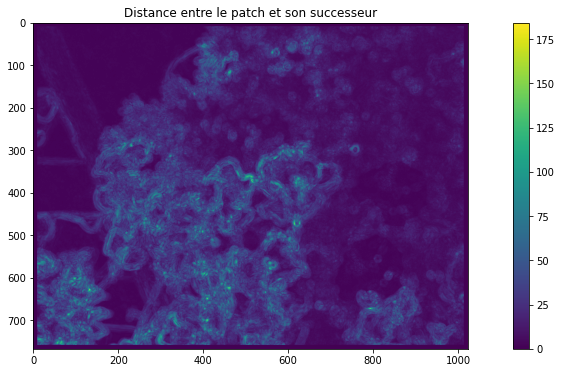

In [31]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch et son successeur')
plt.imshow(a2.dist_field)
plt.colorbar()
plt.show()